### Import

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import *
from vvm_var_func import *

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn.colors.xkcd_rgb as c
import cmaps
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Calculation of initial profile

In [2]:
def ccequation(temperature:float):
    es0 = 6.11   # mb
    Rv  = 461
    Lv  = 2.5e6  # J/kg
    T0  = 273    # K
    return es0*np.exp(Lv/Rv*(1/T0-1/temperature))

In [4]:
def theta_to_temp(pressure:float, theta:float):
    Rd = 287
    Cp = 1004
    return theta*(pressure/1000)**(Rd/Cp)

In [16]:
def derive_qvs(pressure:float, temperature:float):
    epsilon = 287/461
    es      = ccequation(temperature)
    return epsilon*(es/pressure)

In [17]:
def derive_qv_from_RH(pressure:float, temperature:float, RH:float):
    qvs     = derive_qvs(pressure, temperature)
    return qvs*RH

#### Calculation of three points

In [18]:
# Surface: 1000hPa, theta=294K
temp_surf = theta_to_temp(pressure=1000, theta=294)
qv_surf   = derive_qv_from_RH(pressure=1000, temperature=temp_surf, RH=0.8)
print(f"Temperature at surface = {temp_surf} K.")
print(f"qv at surface          = {qv_surf*1e3:5.3f} g/kg.")

Temperature at surface = 294.0 K.
qv at surface          = 12.576 g/kg.


In [19]:
# Sounding1: 780hPa, theta=310K
temp_s1 = theta_to_temp(pressure=780, theta=310)
qv_s1   = derive_qv_from_RH(pressure=780, temperature=temp_s1, RH=0.8)
print(f"Temperature at high level of sounding 1 = {temp_s1} K.")
print(f"qv at high level of sounding 1          = {qv_s1*1e3:5.3f} g/kg.")

Temperature at high level of sounding 1 = 288.7461662270175 K.
qv at high level of sounding 1          = 11.526 g/kg.


In [20]:
# Sounding1: 780hPa, theta=316K
temp_s2 = theta_to_temp(pressure=780, theta=316)
qv_s2   = derive_qv_from_RH(pressure=780, temperature=temp_s2, RH=0.8)
print(f"Temperature at high level of sounding 2 = {temp_s2} K.")
print(f"qv at high level of sounding 2          = {qv_s2*1e3:5.3f} g/kg.")

Temperature at high level of sounding 2 = 294.33480170237914 K.
qv at high level of sounding 2          = 16.464 g/kg.


## Simulation Analysis

### Case list

In [2]:
case_name={'cs1':'pbl_mod_wfire_coastal_s1', 
           'cs2':'pbl_mod_wfire_coastal_s2',
           'is1':'pbl_mod_wfire_inland_s1',
           'is2':'pbl_mod_wfire_inland_s2'}

### Load multi-timestep varfiles

#### cs1: coastal sounding 1

In [3]:
ds_dyn_cs1 = xr.open_mfdataset(f'/data/mlcloud/ch995334/VVM/DATA/{case_name["cs1"]}/archive/{case_name["cs1"]}.L.Dynamic*')

In [4]:
ds_thm_cs1 = xr.open_mfdataset(f'/data/mlcloud/ch995334/VVM/DATA/{case_name["cs1"]}/archive/{case_name["cs1"]}.L.Thermodynamic*')

In [5]:
ds_chem_cs1= xr.open_mfdataset(f'/data/mlcloud/ch995334/VVM/DATA/{case_name["cs1"]}/archive/{case_name["cs1"]}.L.Chemical*')

In [6]:
ds_tra_cs1 = xr.open_mfdataset(f'/data/mlcloud/ch995334/VVM/DATA/{case_name["cs1"]}/archive/{case_name["cs1"]}.L.Tracer*')

In [7]:
# Winds
u_cs1, v_cs1, w_cs1 = ds_dyn_cs1.u, ds_dyn_cs1.v, ds_dyn_cs1.w
# Theta
th_cs1 = ds_thm_cs1.th
# Tracer
tr01_cs1, tr02_cs1  = ds_tra_cs1.tr01, ds_tra_cs1.tr02
# NOx
NO_cs1, NO2_cs1     = ds_chem_cs1.NO, ds_chem_cs1.NO2
# O3
O3_cs1              = ds_chem_cs1.O3

#### cs2: coastal sounding 2

In [8]:
ds_dyn_cs2 = xr.open_mfdataset(f'/data/mlcloud/ch995334/VVM/DATA/{case_name["cs2"]}/archive/{case_name["cs2"]}.L.Dynamic*')

In [9]:
ds_thm_cs2 = xr.open_mfdataset(f'/data/mlcloud/ch995334/VVM/DATA/{case_name["cs2"]}/archive/{case_name["cs2"]}.L.Thermodynamic*')

In [10]:
ds_chem_cs2= xr.open_mfdataset(f'/data/mlcloud/ch995334/VVM/DATA/{case_name["cs2"]}/archive/{case_name["cs2"]}.L.Chemical*')

In [11]:
ds_tra_cs2 = xr.open_mfdataset(f'/data/mlcloud/ch995334/VVM/DATA/{case_name["cs2"]}/archive/{case_name["cs2"]}.L.Tracer*')

In [12]:
# Winds
u_cs2, v_cs2, w_cs2 = ds_dyn_cs2.u, ds_dyn_cs2.v, ds_dyn_cs2.w
# Theta
th_cs2 = ds_thm_cs2.th
# Tracer
tr01_cs2, tr02_cs2  = ds_tra_cs2.tr01, ds_tra_cs2.tr02
# NOx
NO_cs2, NO2_cs2     = ds_chem_cs2.NO, ds_chem_cs2.NO2
# O3
O3_cs2              = ds_chem_cs2.O3

### PBL boundary

#### Height where theta=theta(lev=0)+0.5K

In [14]:
def find_level(pt, levels):
    # Iterate over levels and find the first level where pt >= pt[lev0] + 0.5
    target_temp = pt[0] + 0.5
    idx = np.argmax(pt >= target_temp, axis=0)
    
    # Set to 0 if no level satisfies the condition
    idx = np.where(np.any(pt >= target_temp, axis=0), idx, 0)
    return levels[idx]

In [15]:
def get_ymean_pblh_theta05(theta:xr.DataArray):
    return xr.apply_ufunc(find_level,
                          theta,
                          theta.lev,
                          input_core_dims=[['lev'], ['lev']],
                          vectorize=True,  # Apply across all other dimensions
                          dask="parallelized",  # Use Dask for larger datasets
                          output_dtypes=[float]  # Output will be float
                         ).mean(dim=['lat'])

##### cs1

In [16]:
th05_cs1 = get_ymean_pblh_theta05(th_cs1)

In [17]:
arr_th05_cs1 = th05_cs1.values

In [18]:
arr_th05_cs1.shape

(721, 128)

##### cs2

In [19]:
th05_cs2 = get_ymean_pblh_theta05(th_cs2)

In [20]:
arr_th05_cs2 = th05_cs2.values

#### d_theta/dz max

In [21]:
def get_ymean_pblh_dthdz(theta:xr.DataArray):
    arr_theta = theta.values
    slope     = (arr_theta[:, 1:, ...]-arr_theta[:, :-1, ...])/0.02
    arr_slope_idx = np.argmax(slope, axis=1)
    slope_idx = xr.DataArray(arr_slope_idx, dims=['time', 'lat', 'lon'])
    dthdz_H   = theta.lev.isel(lev=slope_idx).mean(dim=['lat'])
    return dthdz_H

##### cs1

In [22]:
dthdzH_cs1 = get_ymean_pblh_dthdz(th_cs1)

In [23]:
arr_dthdzH_cs1 = dthdzH_cs1.values

In [24]:
arr_dthdzH_cs1.shape

(721, 128)

##### cs2

In [25]:
dthdzH_cs2 = get_ymean_pblh_dthdz(th_cs2)

In [26]:
arr_dthdzH_cs2 = dthdzH_cs2.values

### Tracer 01 (Single point emmision)

#### Snapshot (y-mean)

In [27]:
def Plot_tr01_ymean(time:int, case:str, figpath=False):
    # Case data
    th05   = eval(f'arr_th05_{case}')
    dthdzH = eval(f'arr_dthdzH_{case}')
    tr01   = eval(f'tr01_{case}')
    u, w   = eval(f'u_{case}'), eval(f'w_{case}')
    # Figure
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.grid(':', linewidth=0.5)
    x      = np.arange(tr01.lon.shape[0])
    ## Tracer 01
    bounds = np.arange(0, 1.1, 0.1)
    im     = ax.contourf(x, tr01.lev, tr01.isel(time=time).mean(dim='lat'), 
                         levels=bounds, cmap=cmaps.WhiteYellowOrangeRed, extend='max')
    cbar   = fig.colorbar(im, extend='max')
    cbar.set_ticks(ticks=bounds, labels=[f'{i:3.1f}' for i in bounds])
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label('kg/kg', fontsize=14)
    ## Wind
    ax.quiver(x[::2], tr01.lev[::2], 
              u.isel(time=time).mean(dim='lat')[::2, ::2], 
              w.isel(time=time).mean(dim='lat')[::2, ::2], angles='xy')
    ## Theta+0.5
    ax.plot(x, th05[time, :], 'k', linewidth=3, label=r'$\theta$(z=0) +0.5K')
    ## max. theta variability
    ax.plot(x, dthdzH[time, :], color='grey', linewidth=3, label=r'd$\theta$/dz max.')
    # Info settings
    ax.text(x=x[20], y=-0.22, s='Ocean', color=c['deep sea blue'], fontsize=16, fontweight='bold')
    ax.text(x=x[86], y=-0.22, s='Forest', color=c['sap green'], fontsize=16, fontweight='bold')
    ax.set_xticks(np.arange(0, x.shape[0]+0.1, 32))
    ax.set_xticklabels([f'{i:4.2f}' for i in np.arange(0, 2.561, 0.64)], fontsize=13)
    ax.set_xlabel('x (km)', fontsize=14)
    ax.set_yticks(np.arange(0, 1.9, 0.25))
    ax.set_yticklabels(np.arange(0, 1.9, 0.25), fontsize=13)
    ax.set_ylabel('Height (km)', fontsize=14)
    ax.legend(loc='upper right', fontsize=14)
    ax.set_title('Tracer 01', fontsize=16)
    ax.set_title('y-mean', loc='right', fontsize=12)
    ax.set_title(f'Time = {(datetime(2024, 1, 1, 5)+timedelta(seconds=120*time)).strftime("%H:%M:%S")}', 
                 loc='left', fontsize=12)
    if figpath:
        plt.savefig(f'./Figure/{figpath}/tr01_ts_{time:03d}.png', bbox_inches='tight',
                    facecolor='w', dpi=400)
    else:
        plt.show()

In [ ]:
for i in range(tr01_cs1.time.shape[0]):
    Plot_tr01_ymean(time=i, case='cs1', figpath='hw5_cs1_tr01')

In [ ]:
for i in range(tr01_cs2.time.shape[0]):
    Plot_tr01_ymean(time=i, case='cs2', figpath='hw5_cs2_tr01')

In [ ]:
!ffmpeg -r 10 -f image2 -y -pattern_type glob -i './Figure/hw5_cs1_tr01/*.png' -q:v 1 -vcodec libx264 -crf 25 -pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" ./Figure/hw5_cs1_tr01/hw5_cs1_tr01_ymean.mp4

#### Hovmoeller (certain level, y-mean)

In [72]:
def Plot_tr01_hovm_lev(level:int, case:str, figpath=False):
    # Case data
    tr01     = eval(f'tr01_{case}')
    tr01_lev = tr01.sel(lev=level, method='nearest').mean(dim='lat')
    norm_tr01= (tr01_lev-tr01_lev.min())/(tr01_lev.max()-tr01_lev.min())
    # Figure
    fig, ax  = plt.subplots(figsize=(8, 6))
    x        = np.arange(tr01.lon.shape[0])
    imtr01   = ax.contourf(x, np.arange(721), norm_tr01, levels=np.arange(0, 1.1, 0.1), cmap=cmaps.WhiteYellowOrangeRed)
    cbar     = fig.colorbar(imtr01)
    # Borderline
    ax.vlines(x=63.5, ymin=0, ymax=721, color='k', linewidth=2)
    # Info settings
    ax.grid(linestyle=':', linewidth=0.5, color='grey')
    ax.set_xticks(np.arange(0, 128.1, 32))
    ax.set_xticklabels([f'{i:4.1f}' for i in np.arange(0, 25.61, 6.4)], fontsize=12)
    ax.set_xlabel('(km)', fontsize=14)
    ax.set_ylim(0, 721)
    ax.set_yticks(np.arange(0, 722, 120))
    ax.set_yticklabels([f'{(datetime(2024, 1, 1, 5)+timedelta(seconds=120*time)).strftime("%H:%M")}' for time in range(0, 722, 120)], fontsize=12)
    ax.set_ylabel('Day0    ->    Day1', fontsize=14)
    ax.text(x=x[20], y=-80, s='Ocean', color=c['deep sea blue'], fontsize=16, fontweight='bold')
    ax.text(x=x[86], y=-80, s='Forest', color=c['sap green'], fontsize=16, fontweight='bold')
    ax.set_title('Tr01', fontsize=16, fontweight='bold')
    ax.set_title('y-mean', loc='right', fontsize=14)
    ax.set_title(f'{case[1:]}', loc='left', fontsize=14)
    
    if figpath:
        plt.savefig(f'./Figure/{figpath}/tr01_{case}.png', bbox_inches='tight',
                    facecolor='w', dpi=400)
    else:
        plt.show()

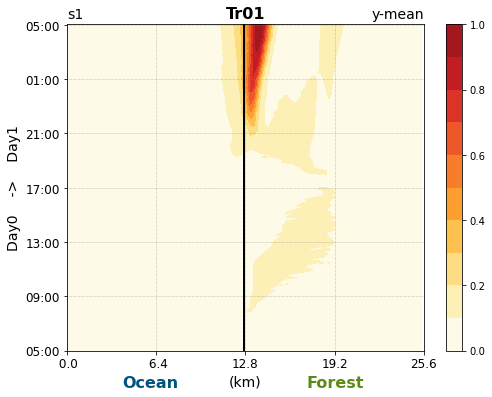

In [73]:
Plot_tr01_hovm_lev(level=0, case='cs1', figpath='hw7_x_hov')

In [ ]:
Plot_tr01_hovm_lev(level=0, case='cs2', figpath='hw7_x_hov')

### Tracer 02 (Areal Emission)

In [53]:
def Plot_tr02_ymean(time:int, case:str, figpath=False):
    # Case data
    th05   = eval(f'arr_th05_{case}')
    dthdzH = eval(f'arr_dthdzH_{case}')
    tr02   = eval(f'tr02_{case}') 
    u, w   = eval(f'u_{case}'), eval(f'w_{case}')
    # Figure
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.grid(':', linewidth=0.5)
    x      = np.arange(tr02.lon.shape[0])
    ## Tracer 02
    bounds = np.arange(0, 100.1, 10)
    im     = ax.contourf(x, tr02.lev, tr02.isel(time=time).mean(dim='lat'), 
                         levels=bounds, cmap=cmaps.WhiteYellowOrangeRed, extend='max')
    cbar   = fig.colorbar(im, extend='max')
    cbar.set_ticks(ticks=bounds, labels=[f'{i:3.0f}' for i in bounds])
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label('kg/kg', fontsize=14)
    ## Wind
    ax.quiver(x[::2], tr02.lev[::2], 
              u.isel(time=time).mean(dim='lat')[::2, ::2], 
              w.isel(time=time).mean(dim='lat')[::2, ::2], angles='xy')
    ## Theta+0.5
    ax.plot(x, th05[time, :], 'k', linewidth=3, label=r'$\theta$(z=0) +0.5K')
    ## max. theta variability
    ax.plot(x, dthdzH[time, :], color='grey', linewidth=3, label=r'd$\theta$/dz max.')
    # Info settings
    ax.text(x=x[20], y=-0.22, s='Ocean', color=c['deep sea blue'], fontsize=16, fontweight='bold')
    ax.text(x=x[86], y=-0.22, s='Forest', color=c['sap green'], fontsize=16, fontweight='bold')
    ax.set_xticks(np.arange(0, x.shape[0]+0.1, 32))
    ax.set_xticklabels([f'{i:4.2f}' for i in np.arange(0, 2.561, 0.64)], fontsize=13)
    ax.set_xlabel('x (km)', fontsize=14)
    ax.set_yticks(np.arange(0, 1.9, 0.25))
    ax.set_yticklabels(np.arange(0, 1.9, 0.25), fontsize=13)
    ax.set_ylabel('Height (km)', fontsize=14)
    ax.legend(loc='upper right', fontsize=14)
    ax.set_title('Tracer 02', fontsize=16)
    ax.set_title('y-mean', loc='right', fontsize=12)
    ax.set_title(f'Time = {(datetime(2024, 1, 1, 5)+timedelta(seconds=120*time)).strftime("%H:%M:%S")}', 
                 loc='left', fontsize=12)
    if figpath:
        plt.savefig(f'./Figure/{figpath}/tr01_ts_{time:03d}.png', bbox_inches='tight',
                    facecolor='w', dpi=400)
    else:
        plt.show()

In [ ]:
for i in range(tr02_cs1.shape[0]):
    Plot_tr02_ymean(time=i, case='cs1', figpath='hw5_cs1_tr02')

In [ ]:
for i in range(tr02_cs2.shape[0]):
    Plot_tr02_ymean(time=i, case='cs2', figpath='hw5_cs2_tr02')

In [ ]:
!ffmpeg -r 10 -f image2 -y -pattern_type glob -i './Figure/hw5_cs2_tr02/*.png' -q:v 1 -vcodec libx264 -crf 25 -pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" ./Figure/hw5_cs2_tr02/hw5_cs2_tr02_ymean.mp4

In [111]:
def Plot_tracer_dmean(case:str, figpath=False):
    # Case data
    th05   = eval(f'arr_th05_{case}')
    dthdzH = eval(f'arr_dthdzH_{case}')
    tr01_mean = eval(f'tr01_{case}').mean(dim=['lat', 'lon'])
    tr02_mean = eval(f'tr02_{case}').mean(dim=['lat', 'lon'])
    # Normalize tracer concentration
    tr01_norm = (tr01_mean-tr01_mean.min())/(tr01_mean.max()-tr01_mean.min())
    tr02_norm = (tr02_mean-tr02_mean.min())/(tr02_mean.max()-tr02_mean.min())
    # Figure
    fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'wspace':0.1}, sharex=True, sharey=True)
    x      = tr01.time
    ## tr01
    ax[0].grid(':', linewidth=0.5)
    bounds = np.arange(0, 1.025, 0.025)
    im_o01 = ax[0].contourf(x, NO2.lev, NO2.isel(lon=slice(None, 63)).mean(dim=['lat', 'lon']).T, 
                         levels=bounds, cmap=cmaps.WhiteBlueGreenYellowRed, extend='max')
    cax    = fig.add_axes([ax[1].get_position().x1+0.01, ax[1].get_position().y0, 0.015, ax[1].get_position().height])
    cbar   = fig.colorbar(im_ocn, extend='max', cax=cax)
    cbar.set_ticks(ticks=bounds[::2], labels=[f'{i:3.0f}' for i in bounds[::2]])
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label('ppb', fontsize=14)
    ax[1].grid(':', linewidth=0.5)
    im_frst= ax[1].contourf(x, NO2.lev, NO2.isel(lon=slice(64, None)).mean(dim=['lat', 'lon']).T, 
                         levels=bounds, cmap=cmaps.WhiteBlueGreenYellowRed, extend='max')
    """cbar   = fig.colorbar(im_frst, extend='max')
    cbar.set_ticks(ticks=bounds, labels=[f'{i:3.1f}' for i in bounds])
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label('ppb', fontsize=14)"""
    ## Theta+0.5
    ax[0].plot(x, np.mean(th05[:, :64], axis=1), 'k', linewidth=3, label=r'$\theta$(z=0) +0.5K')
    ax[1].plot(x, np.mean(th05[:, 64:], axis=1), 'k', linewidth=3, label=r'$\theta$(z=0) +0.5K')
    ## max. theta variability
    ax[0].plot(x, np.mean(dthdzH[:, :64], axis=1), color='grey', linewidth=3, label=r'd$\theta$/dz max.')
    ax[1].plot(x, np.mean(dthdzH[:, 64:], axis=1), color='grey', linewidth=3, label=r'd$\theta$/dz max.')
    # Info settings
    #ax.text(x=x[20], y=-0.22, s='Ocean', color=c['deep sea blue'], fontsize=16, fontweight='bold')
    #ax.text(x=x[86], y=-0.22, s='Forest', color=c['sap green'], fontsize=16, fontweight='bold')
    ax[0].set_xticks(NO2.time[::180])
    ax[0].set_xticklabels([f'{NO2.time.dt.hour[i]+5:02d}:{NO2.time.dt.minute[i]:02d}' for i in range(0, NO2.shape[0], 180)], 
                       fontsize=13)
    ax[0].set_xlabel('Local time', fontsize=14)
    ax[0].set_xlabel('x (km)', fontsize=14)
    ax[1].set_xticks(NO2.time[::180])
    ax[1].set_xticklabels([f'{NO2.time.dt.hour[i]+5:02d}:{NO2.time.dt.minute[i]:02d}' for i in range(0, NO2.shape[0], 180)], 
                       fontsize=13)
    ax[1].set_xlabel('Local time', fontsize=14)
    ax[1].set_xlabel('x (km)', fontsize=14)
    ax[0].set_yticks(np.arange(0, 1.9, 0.25))
    ax[0].set_yticklabels(np.arange(0, 1.9, 0.25), fontsize=13)
    ax[0].set_ylabel('Height (km)', fontsize=14)
    ax[0].legend(loc='upper right', fontsize=14)
    ax[0].set_title('Ocean Mean', fontsize=16)
    ax[0].set_title(f'{case[-2:]}', fontsize=16, loc='left')
    ax[1].set_title('Forest Mean', fontsize=16)
    ax[1].set_title('NO2', fontsize=16, loc='right')
    """ax.set_title('y-mean', loc='right', fontsize=12)
    ax.set_title(f'Time = {(datetime(2024, 1, 1, 5)+timedelta(seconds=120*time)).strftime("%H:%M:%S")}', 
                 loc='left', fontsize=12)"""
    if figpath:
        plt.savefig(f'./Figure/{figpath}/{case}.png', bbox_inches='tight',
                    facecolor='w', dpi=400)
    else:
        plt.show()

### NO2 (Areal Emission)

#### Hovmoeller (Domain-average)

In [133]:
def Plot_no2_dmean(case:str, figpath=False):
    # Case data
    th05   = eval(f'arr_th05_{case}')
    dthdzH = eval(f'arr_dthdzH_{case}')
    NO     = eval(f'NO_{case}') 
    NO2    = eval(f'NO2_{case}')
    pblH_wth_ocn = np.load(f'/data/mlcloud/ch995334/hw/Data/hw6_ocn_pblh_wth_{case}.npy', allow_pickle=True).item()
    pblH_wth_frst= np.load(f'/data/mlcloud/ch995334/hw/Data/hw6_frst_pblh_wth_{case}.npy', allow_pickle=True).item()
    # Figure
    fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'wspace':0.1}, sharex=True, sharey=True)
    x      = NO2.time
    ## NO2
    ax[0].grid(':', linewidth=0.5)
    bounds = np.arange(0, 2000.1, 100)
    im_ocn = ax[0].contourf(x, NO2.lev, NO2.isel(lon=slice(None, 63)).mean(dim=['lat', 'lon']).T, 
                         levels=bounds, cmap=cmaps.WhiteBlueGreenYellowRed, extend='max')
    cax    = fig.add_axes([ax[1].get_position().x1+0.01, ax[1].get_position().y0, 0.015, ax[1].get_position().height])
    cbar   = fig.colorbar(im_ocn, extend='max', cax=cax)
    cbar.set_ticks(ticks=bounds[::2], labels=[f'{i:3.0f}' for i in bounds[::2]])
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label('ppb', fontsize=14)
    ax[1].grid(':', linewidth=0.5)
    im_frst= ax[1].contourf(x, NO2.lev, NO2.isel(lon=slice(64, None)).mean(dim=['lat', 'lon']).T, 
                         levels=bounds, cmap=cmaps.WhiteBlueGreenYellowRed, extend='max')
    """cbar   = fig.colorbar(im_frst, extend='max')
    cbar.set_ticks(ticks=bounds, labels=[f'{i:3.1f}' for i in bounds])
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label('ppb', fontsize=14)"""
    ## Theta+0.5
    ax[0].plot(x, np.mean(th05[:, :64], axis=1), 'k', linewidth=3, label=r'$\theta$(z=0) +0.5K')
    ax[1].plot(x, np.mean(th05[:, 64:], axis=1), 'k', linewidth=3)
    ## max. theta variability
    ax[0].plot(x, np.mean(dthdzH[:, :64], axis=1), color='grey', linewidth=3, label=r'd$\theta$/dz max.')
    ax[1].plot(x, np.mean(dthdzH[:, 64:], axis=1), color='grey', linewidth=3)
    ## w'th' change sign
    ax[0].plot(x, np.asarray(pblH_wth_ocn['pblH_1st0'])*1e-3, color=c['denim'], linewidth=3)
    ax[1].plot(x, np.asarray(pblH_wth_ocn['pblH_1st0'])*1e-3, color=c['denim'], linewidth=3, label=r'vert. $\theta$ flux=0')
    ## w'th' most negative
    ax[0].plot(x, np.asarray(pblH_wth_ocn['pblH_negmax'])*1e-3, color=c['burnt sienna'], linewidth=3)
    ax[1].plot(x, np.asarray(pblH_wth_ocn['pblH_negmax'])*1e-3, color=c['burnt sienna'], linewidth=3, label=r'vert. $\theta$ flux min.')
    # Info settings
    #ax.text(x=x[20], y=-0.22, s='Ocean', color=c['deep sea blue'], fontsize=16, fontweight='bold')
    #ax.text(x=x[86], y=-0.22, s='Forest', color=c['sap green'], fontsize=16, fontweight='bold')
    ax[0].set_xticks(NO2.time[::180])
    ax[0].set_xticklabels([f'{NO2.time.dt.hour[i]+5:02d}:{NO2.time.dt.minute[i]:02d}' for i in range(0, NO2.shape[0], 180)], 
                       fontsize=13)
    ax[0].set_xlabel('Local time', fontsize=14)
    ax[0].set_xlabel('x (km)', fontsize=14)
    ax[1].set_xticks(NO2.time[::180])
    ax[1].set_xticklabels([f'{NO2.time.dt.hour[i]+5:02d}:{NO2.time.dt.minute[i]:02d}' for i in range(0, NO2.shape[0], 180)], 
                       fontsize=13)
    ax[1].set_xlabel('Local time', fontsize=14)
    ax[1].set_xlabel('x (km)', fontsize=14)
    ax[0].set_yticks(np.arange(0, 1.9, 0.25))
    ax[0].set_yticklabels(np.arange(0, 1.9, 0.25), fontsize=13)
    ax[0].set_ylabel('Height (km)', fontsize=14)
    ax[0].legend(loc='upper right', fontsize=12)
    ax[0].set_title('Ocean Mean', fontsize=16)
    ax[0].set_title(f'{case[-2:]}', fontsize=16, loc='left')
    ax[1].set_title('Forest Mean', fontsize=16)
    ax[1].set_title('NO2', fontsize=16, loc='right')
    ax[1].legend(loc='upper right', fontsize=12)
    """ax.set_title('y-mean', loc='right', fontsize=12)
    ax.set_title(f'Time = {(datetime(2024, 1, 1, 5)+timedelta(seconds=120*time)).strftime("%H:%M:%S")}', 
                 loc='left', fontsize=12)"""
    if figpath:
        plt.savefig(f'./Figure/{figpath}/{case}_4pblh.png', bbox_inches='tight',
                    facecolor='w', dpi=400)
    else:
        plt.show()

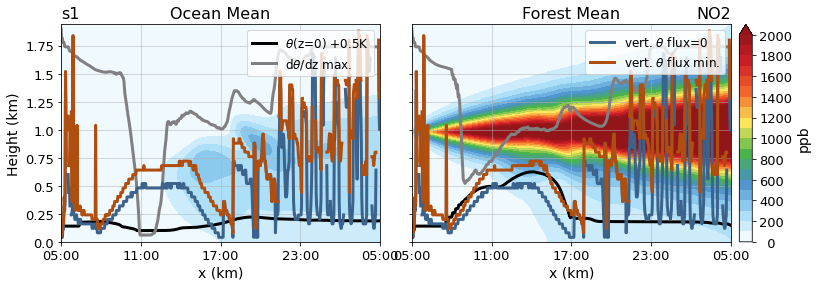

In [134]:
Plot_no2_dmean(case='cs1', figpath='hw6_no2_hovmoeller')

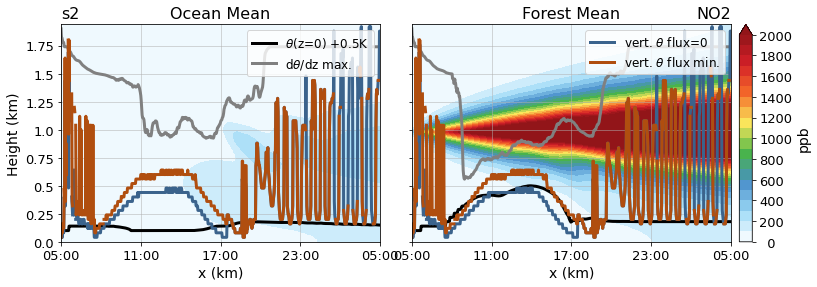

In [135]:
Plot_no2_dmean(case='cs2', figpath='hw6_no2_hovmoeller')

#### Hovmoeller (y-mean)

In [66]:
def Plot_nox_hovm_lev(level:int, case:str, figpath=False):
    # Case data
    NO     = eval(f'NO_{case}').sel(lev=level, method='nearest').mean(dim='lat')
    NO2    = eval(f'NO2_{case}').sel(lev=level, method='nearest').mean(dim='lat')
    NOx    = NO+NO2
    #norm_tr01= (tr01_lev-tr01_lev.min())/(tr01_lev.max()-tr01_lev.min())
    # Figure
    fig, ax  = plt.subplots(figsize=(8, 6))
    x        = np.arange(NO.lon.shape[0])
    imnox    = ax.contourf(x, np.arange(721), NOx, levels=np.arange(0, 2800.1, 200), cmap=cmaps.WhiteBlueGreenYellowRed)
    cbar     = fig.colorbar(imnox)
    cbar.set_label('ppb', fontsize=14)
    # Borderline
    ax.vlines(x=63.5, ymin=0, ymax=721, color='k', linewidth=2)
    # Info settings
    ax.grid(linestyle=':', linewidth=0.5, color='grey')
    ax.set_xticks(np.arange(0, 128.1, 32))
    ax.set_xticklabels([f'{i:4.2f}' for i in np.arange(0, 2.561, 0.64)], fontsize=12)
    ax.set_xlabel('(km)', fontsize=14)
    ax.set_ylim(0, 721)
    ax.set_yticks(np.arange(0, 722, 120))
    ax.set_yticklabels([f'{(datetime(2024, 1, 1, 5)+timedelta(seconds=120*time)).strftime("%H:%M")}' for time in range(0, 722, 120)], fontsize=12)
    ax.set_ylabel('Day0    ->    Day1', fontsize=14)
    ax.text(x=x[20], y=-80, s='Ocean', color=c['deep sea blue'], fontsize=16, fontweight='bold')
    ax.text(x=x[86], y=-80, s='Forest', color=c['sap green'], fontsize=16, fontweight='bold')
    ax.set_title('NOx', fontsize=16, fontweight='bold')
    ax.set_title('y-mean', loc='right', fontsize=14)
    ax.set_title(f'{case[1:]}', loc='left', fontsize=14)
    
    if figpath:
        plt.savefig(f'./Figure/{figpath}/nox_{case}.png', bbox_inches='tight',
                    facecolor='w', dpi=400)
    else:
        plt.show()

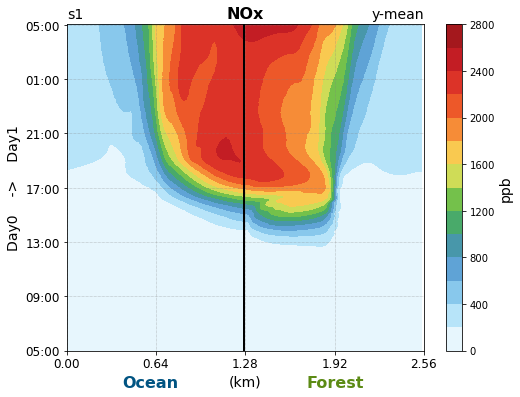

In [70]:
Plot_nox_hovm_lev(level=0, case='cs1', figpath='hw7_x_hov')

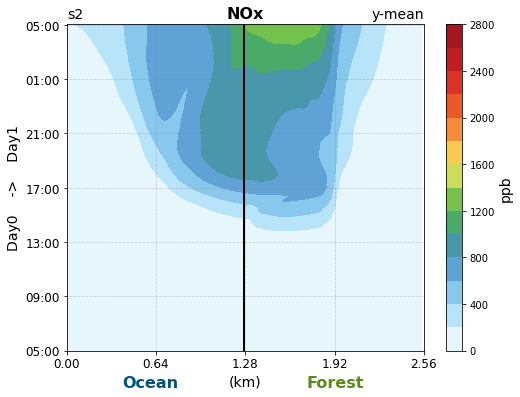

In [71]:
Plot_nox_hovm_lev(level=0, case='cs2', figpath='hw7_x_hov')

### Class Practice

In [81]:
# !!! Only Jupyter !!!
import vvmtools
import importlib

importlib.reload(vvmtools)   # Can I pass multiple module in the argument list?

<module 'vvmtools' from '/data/mlcloud/ch995334/hw/vvmtools.py'>

#### Test

In [62]:
class Person:
    def __init__(self, Age, Name):   # all func in class should share "self"
        self.age = Age
        self.name= Name
    
    def greet(self):
        print("Hi")
        

In [61]:
person1 = Person(Age=20, Name="Alice")
print(person1)

In [63]:
class Student(Person):
    def __init__(self, Age, Name, ID):
        super().__init__(Age=Age, Name=Name)
        self.ID=ID

mog=Student(Age=20, )

#### VVM tools

In [82]:
VVMTools = vvmtools.VVMTools

In [83]:
VVMObjects = VVMTools("/data/mlcloud/Aaron/VVM/DATA/chem_3tc_2/")

In [70]:
domain = (0, 1, 0, 1, None, None)   # (k1, k2, j1, j2, i1, i2)
VVMObjects.get_var(var="u", time=100, domain_range=domain)

<xarray.DataArray 'u' (lev: 1, lat: 1, lon: 128)>
array([[[ 0.015746,  0.008491, -0.021098,  0.005678, -0.016179, -0.003983,
          0.010579, -0.010363,  0.002232, -0.015732,  0.027144, -0.007982,
         -0.000502, -0.001187, -0.009639,  0.007989, -0.006968,  0.009887,
         -0.012352, -0.006057,  0.014046, -0.015119, -0.001842,  0.02824 ,
         -0.016977,  0.003356, -0.008079, -0.013428,  0.024732, -0.003984,
         -0.006297, -0.009288,  0.006333, -0.003815,  0.023701, -0.00712 ,
         -0.009126,  0.013806,  0.010573, -0.017073,  0.025671, -0.011095,
         -0.001874,  0.017463,  0.009836, -0.012166,  0.027509,  0.001875,
         -0.003428,  0.002105,  0.011636,  0.009909,  0.00442 ,  0.000539,
          0.01332 , -0.011531,  0.010233,  0.008829,  0.008897, -0.014415,
          0.008214, -0.004874,  0.00691 ,  0.022424, -0.011788, -0.001349,
          0.008868, -0.002517, -0.00688 ,  0.00672 , -0.010204, -0.007243,
          0.028441, -0.009379, -0.00393 , -0.011145,  0.009074,  0.005143,
          0.018244, -0.006635, -0.01734 ,  0.003419,  0.018113, -0.018352,
          0.004606,  0.016892, -0.009182, -0.014465,  0.008233,  0.020662,
         -0.014729, -0.001502, -0.010806,  0.037804, -0.043785,  0.033472,
         -0.022711,  0.012782, -0.03073 ,  0.031937, -0.005169, -0.033883,
          0.000903,  0.001473, -0.013518, -0.007089,  0.023876, -0.033096,
          0.02176 , -0.037348,  0.024368, -0.014256,  0.014755, -0.018196,
         -0.020939,  0.019734, -0.005492,  0.000543, -0.009553,  0.011201,
         -0.025763, -0.000528,  0.002303,  0.009706, -0.022796,  0.023721,
         -0.020549, -0.015537]]], dtype=float32)
Coordinates:
    time     datetime64[ns] 1900-01-01T03:20:00
  * lev      (lev) float64 0.0
  * lat      (lat) float64 -0.1142
  * lon      (lon) float64 -0.1142 -0.1124 -0.1106 ... 0.1106 0.1124 0.1142
Attributes:
    standard_name:  zonal_velocity
    long_name:      zonal velocity
    units:          m s-1

In [86]:
u_tsteps = VVMObjects.get_var_parallel(var="u", time_steps=np.arange(100), domain_range=domain, compute_mean=True, axis=0)
u_tsteps.shape

(100,)

In [92]:
class newVVMTools(VVMTools):
    def __init(self, case_path):
        super().__init__(case_path)
        
    def cal_TKE(self, t):
        u = np.squeeze(self.get_var("u", t, numpy=True))
        v = np.squeeze(self.get_var("v", t, numpy=True))
        w = np.squeeze(self.get_var("w", t, numpy=True))
        
        return np.nanmean((u**2+v**2+w**2)/2, axis=(1, 2))
        
newtools = newVVMTools("/data/mlcloud/Aaron/VVM/DATA/chem_3tc_2/")

tke_mean = newtools.func_time_parallel(newtools.cal_TKE, time_steps=np.arange(0, 10))

In [93]:
tke_mean.shape

(10, 50)

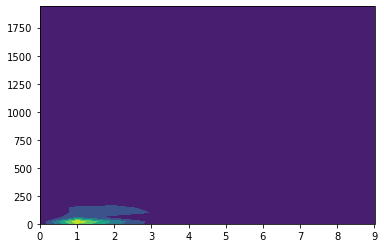

In [96]:
z = newtools.DIM["zc"]
plt.contourf(np.arange(10), z, tke_mean.T)

In [106]:
class addVVMTools(VVMTools):
    def __init__(self, case_path):
        super().__init__(case_path)  # inherit VVMTools (class) by aaron
        
    def cal_enstrophy(self, t):      # create a new function (should assign time step)
        """
        Return domain_averaged enstrophy of given time step.
        """
        xi   = np.squeeze(self.get_var(var="xi", time=t))
        eta  = np.squeeze(self.get_var(var="eta_2", time=t))
        zeta = np.squeeze(self.get_var(var="zeta", time=t))
        return np.nanmean((xi**2+eta**2+zeta**2)/2, axis=(1, 2))

In [100]:
addtools = addVVMTools("/data/mlcloud/Aaron/VVM/DATA/chem_3tc_2/")

In [101]:
enst_mean = addtools.func_time_parallel(addtools.cal_enstrophy, time_steps=np.arange(10))

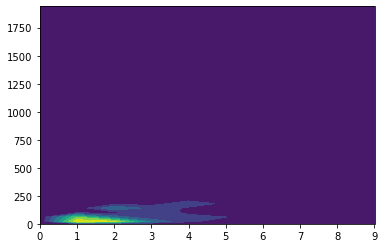

In [103]:
plt.contourf(np.arange(10), z, enst_mean.T)

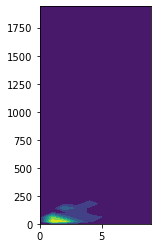

In [105]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.contourf(np.arange(10), z, enst_mean.T)

In [117]:
np.load(f'/data/mlcloud/ch995334/hw/Data/hw6_ocn_pblh_wth_cs1.npy', allow_pickle=True).item()

{'cs1': {'pblH_1st0': [40.0,
   120.0,
   40.0,
   40.0,
   120.0,
   120.0,
   200.0,
   320.0,
   280.0,
   360.0,
   1360.0,
   720.0,
   680.0,
   nan,
   nan,
   nan,
   600.0,
   440.0,
   nan,
   480.0,
   320.0,
   nan,
   nan,
   240.0,
   240.0,
   280.0,
   320.0,
   1680.0,
   280.0,
   240.0,
   240.0,
   200.0,
   200.0,
   200.0,
   240.0,
   240.0,
   200.0,
   200.0,
   200.0,
   160.0,
   160.0,
   200.0,
   200.0,
   200.0,
   200.0,
   160.0,
   160.0,
   160.0,
   160.0,
   160.0,
   160.0,
   160.0,
   160.0,
   160.0,
   160.0,
   160.0,
   160.0,
   160.0,
   160.0,
   160.0,
   160.0,
   160.0,
   160.0,
   160.0,
   160.0,
   160.0,
   160.0,
   160.0,
   160.0,
   160.0,
   120.0,
   120.0,
   120.0,
   120.0,
   160.0,
   160.0,
   160.0,
   160.0,
   120.0,
   120.0,
   120.0,
   120.0,
   80.0,
   80.0,
   80.0,
   80.0,
   80.0,
   80.0,
   80.0,
   80.0,
   120.0,
   120.0,
   120.0,
   120.0,
   120.0,
   120.0,
   120.0,
   120.0,
   120.0,
   160.0,
 